# Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data

In [ ]:
# Load the Generalization Data which got preprocessed just like in the Classic ML Sentiment Analysis
import pandas as pd
# TODO: Change to base_data_path = 'INSERT_PATH'
base_data_path = './drive/MyDrive/Studium_Kempten/Masterarbeit/Azure_Notebooks/Abgabe_Data'
df = pd.read_csv(f'{base_data_path}/generalization.csv')
df

,text_original,text_preprocessed,Sentiment,source
0,I know that there are divided camps when it co...,know divide camp come ship issue part product ...,0,Amazon
1,The owner responded to my Yelp comment and off...,owner respond yelp comment offer sincere apolo...,1,Yelp
2,At first I didn't like the Idea of eating a su...,first idea eat sushi place middle desert makin...,2,Yelp
3,Mass quantities of glop. Skip it.,mass quantity glop skip,0,Yelp
4,This is my daily morning cup of coffee. I lik...,daily morning cup coffee strong coffee become ...,2,Amazon
...,...,...,...,...
29995,This place has a nice selection of Shoes. The ...,place nice selection shoe customer service lac...,1,Yelp
29996,vet recommended dogs love this kind better tha...,vet recommend dog love kind well one note sens...,2,Amazon
29997,I first had Popchips last week at a local deli...,first popchips last week local deli miami impr...,2,Amazon
29998,inexpensive good value chose principal pretty ...,inexpensive good value choose principal pretty...,1,Trip Advisor


# Topic Modeling - Apply LDA Algorithm

## Create Document-Term Matrix for LDA

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Ignore terms with a frequency lower than 0.1 or higher than 0.9
vectorizer = CountVectorizer(max_features=100000, min_df=0.1, max_df=0.9)
features = vectorizer.fit_transform(df["text_preprocessed"])
feature_names = vectorizer.get_feature_names_out()
n_top_words = 10

## Search for the best LDA-parameters using GridSearchCV

In [ ]:
%%time
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

# Initializing the LDA model with specific parameters
lda = LatentDirichletAllocation(
    random_state=42,         # Setting the random seed for reproducibility
    learning_method='online', # Using the online learning method for large datasets
    doc_topic_prior=0.01,    # Dirichlet distribution for document-to-topic distribution
    topic_word_prior=0.01,   # Dirichlet distribution for topic-to-word distribution
    learning_offset=500,     # Constant to stabilize the learning process
    batch_size=2500          # Number of documents per batch during learning
)

# Defining the parameters to be tested in GridSearchCV
# This took about 1 h for the follwing parameters:
search_params = {
    'n_components': [10, 15, 20], # Number of topics to be extracted
    'learning_decay': [.5, .75, .9], # Learning rate (decay) for online learning
}

# Applying GridSearchCV to find the best parameter combinations
model = GridSearchCV(
    lda,                      # The LDA model to be tested
    param_grid=search_params, # The parameter grid to search through
    n_jobs=-1,                # Use all available processors
    error_score='raise',      # Error handling to stop training on errors
    refit=True,               # Refit the model with the best parameters
    return_train_score=True   # Return training results
)

# Fitting the model to the data
model.fit(features)


CPU times: user 1min 56s, sys: 6.46 s, total: 2min 2s
Wall time: 58min 17s


GridSearchCV(error_score='raise',
             estimator=LatentDirichletAllocation(batch_size=2500,
                                                 doc_topic_prior=0.01,
                                                 learning_method='online',
                                                 learning_offset=500,
                                                 random_state=42,
                                                 topic_word_prior=0.01),
             n_jobs=-1,
             param_grid={'learning_decay': [0.5, 0.75, 0.9],
                         'n_components': [10, 15, 20]},
             return_train_score=True)

In [ ]:
best_lda_model = model.best_estimator_
print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)

Best Model's Params:  {'learning_decay': 0.75, 'n_components': 10}
Best Log Likelihood Score:  -392499.94492239144


In [ ]:
best_lda_model

LatentDirichletAllocation(batch_size=2500, doc_topic_prior=0.01,
                          learning_decay=0.75, learning_method='online',
                          learning_offset=500, random_state=42,
                          topic_word_prior=0.01)

## Visualization of results

In [ ]:
import matplotlib.pyplot as plt
def show_topics(model, feature_names, n_top_words):
    topics = model.components_
    fig, axes = plt.subplots(1, len(topics), figsize=(25, 10), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(topics):
        top_features_ind =  topic.argsort()[-n_top_words:][::-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = [topic[i] for i in top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'T {topic_idx}', fontdict={'fontsize': 25}, pad=10, loc='left')
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

        # Drawing a vertical line to the right of the subplot
        ax.spines['right'].set_visible(True)
        ax.spines['right'].set_linewidth(0.3)

        for i in 'top left'.split():
            ax.spines[i].set_visible(False)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

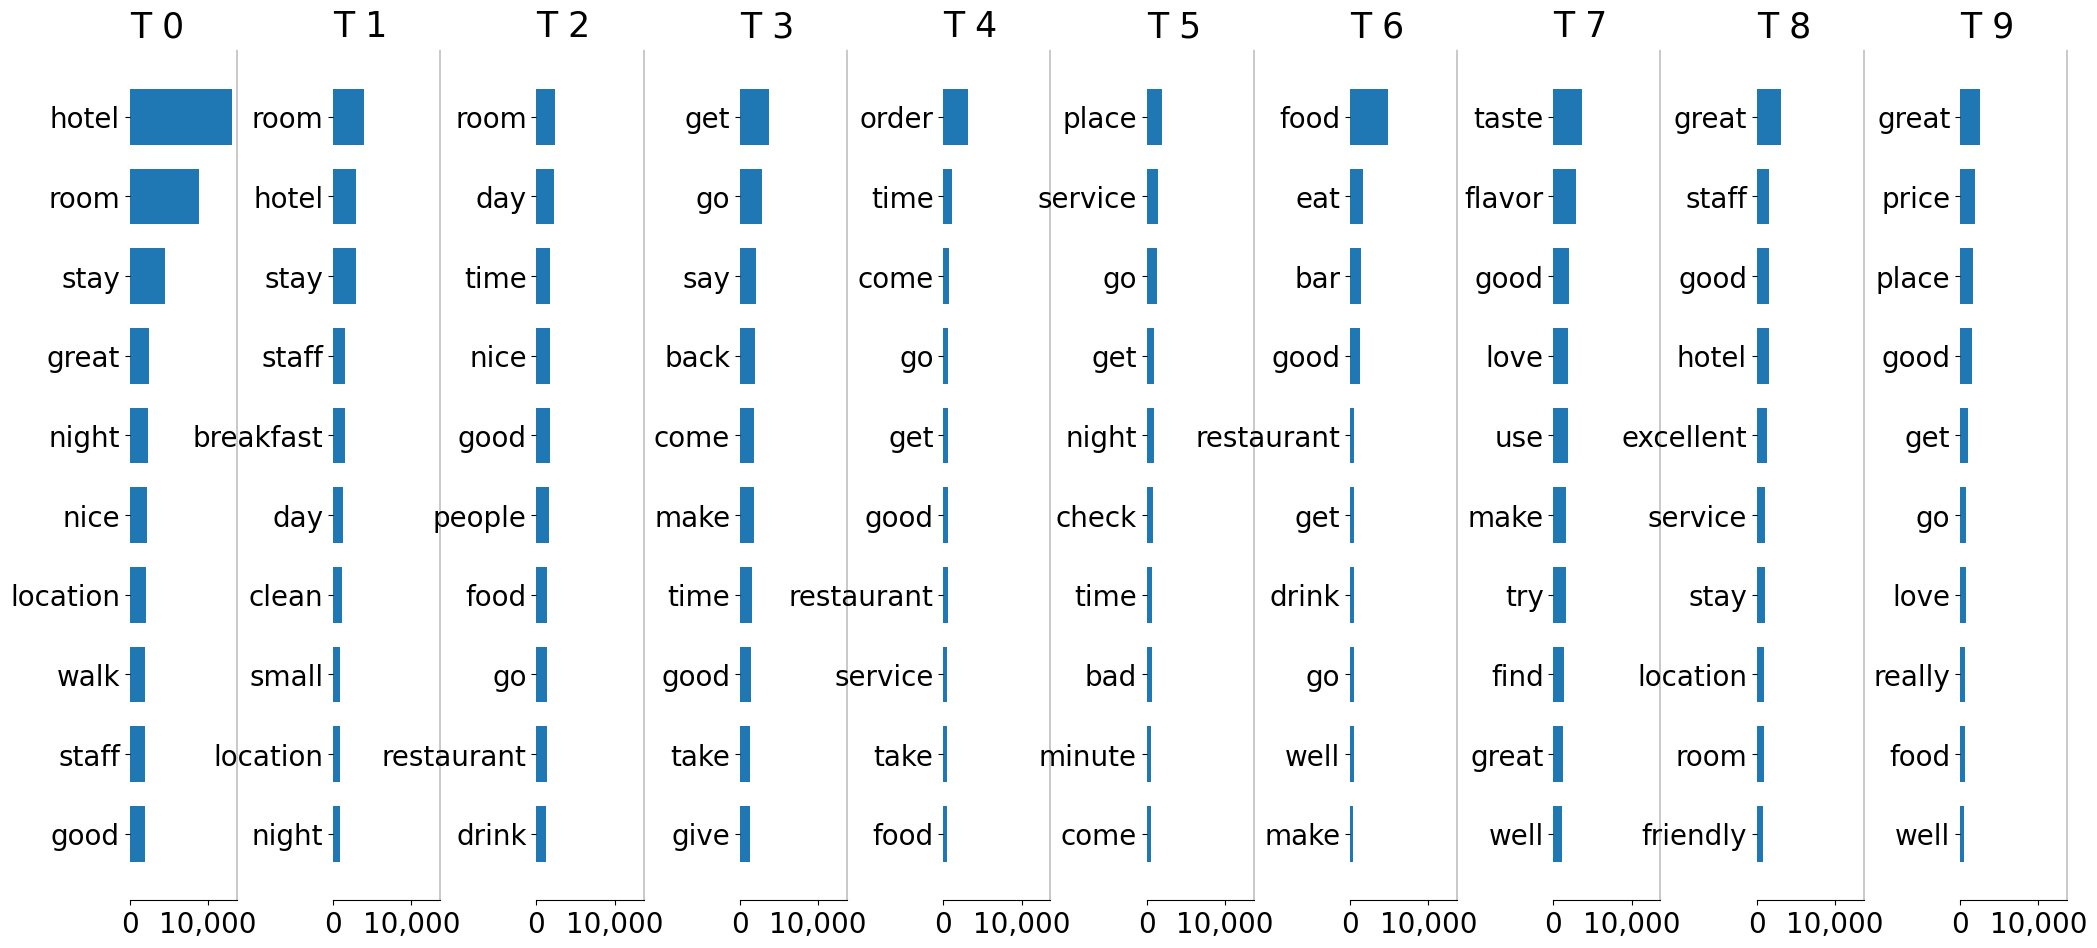

In [ ]:
show_topics(best_lda_model, feature_names, n_top_words)

In [ ]:
def get_lda_component_param(n_components):
    lda_n_components = LatentDirichletAllocation(
        random_state=42,
        learning_method='online',
        doc_topic_prior=0.01,
        topic_word_prior=0.01,
        learning_offset=500,
        batch_size=2500,
        n_components=n_components,
        learning_decay=.75
    )
    lda_n_components.fit(features)

    topic_terms_n_components = lda_n_components.components_.argsort(axis=1)[:, ::-1]
    feature_names_n_components = vectorizer.get_feature_names_out()
    n_top_words_n_components = 10
    show_topics(lda_n_components, feature_names_n_components, n_top_words_n_components)
    return lda_n_components

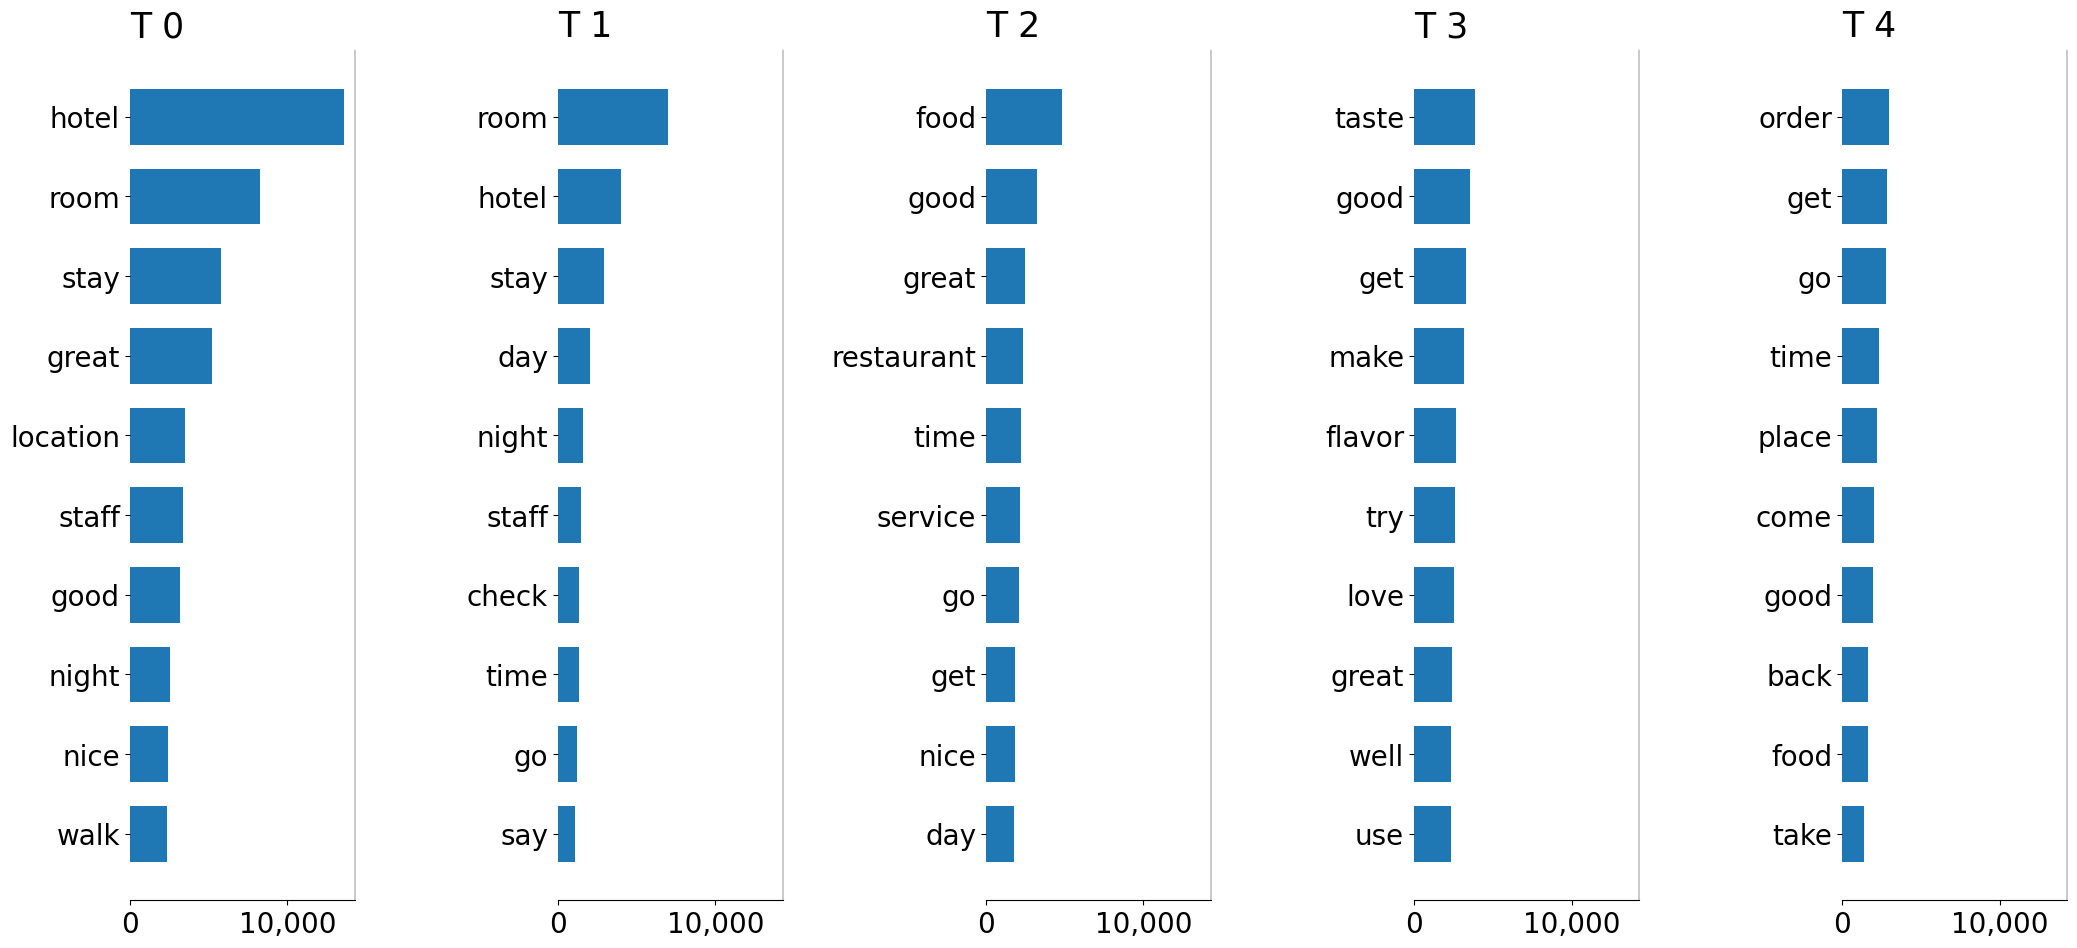

CPU times: user 1min 31s, sys: 724 ms, total: 1min 32s
Wall time: 1min 49s


In [ ]:
%%time
# OPTIONAL: Visualization of 5 topics
lda_5 = get_lda_component_param(5)

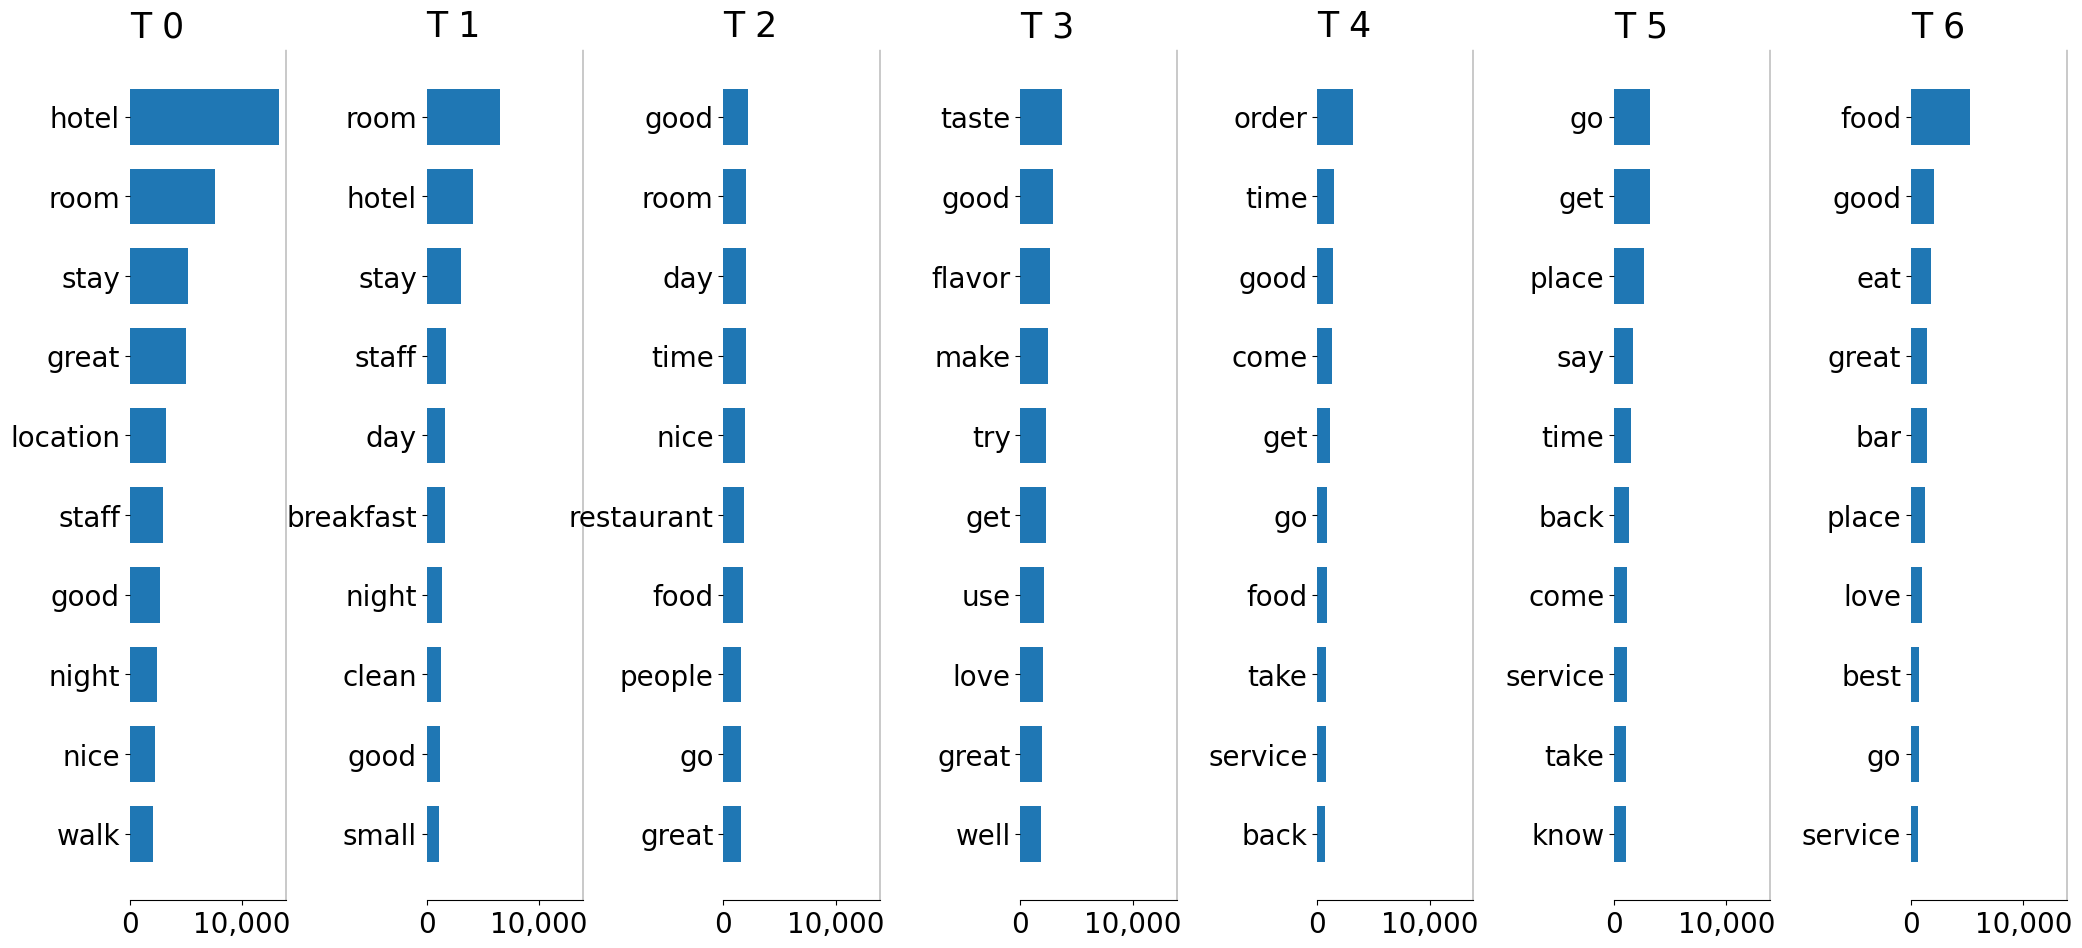

CPU times: user 1min 29s, sys: 787 ms, total: 1min 30s
Wall time: 1min 39s


In [ ]:
%%time
# OPTIONAL: Visualization of 7 topics
lda_7 = get_lda_component_param(7)

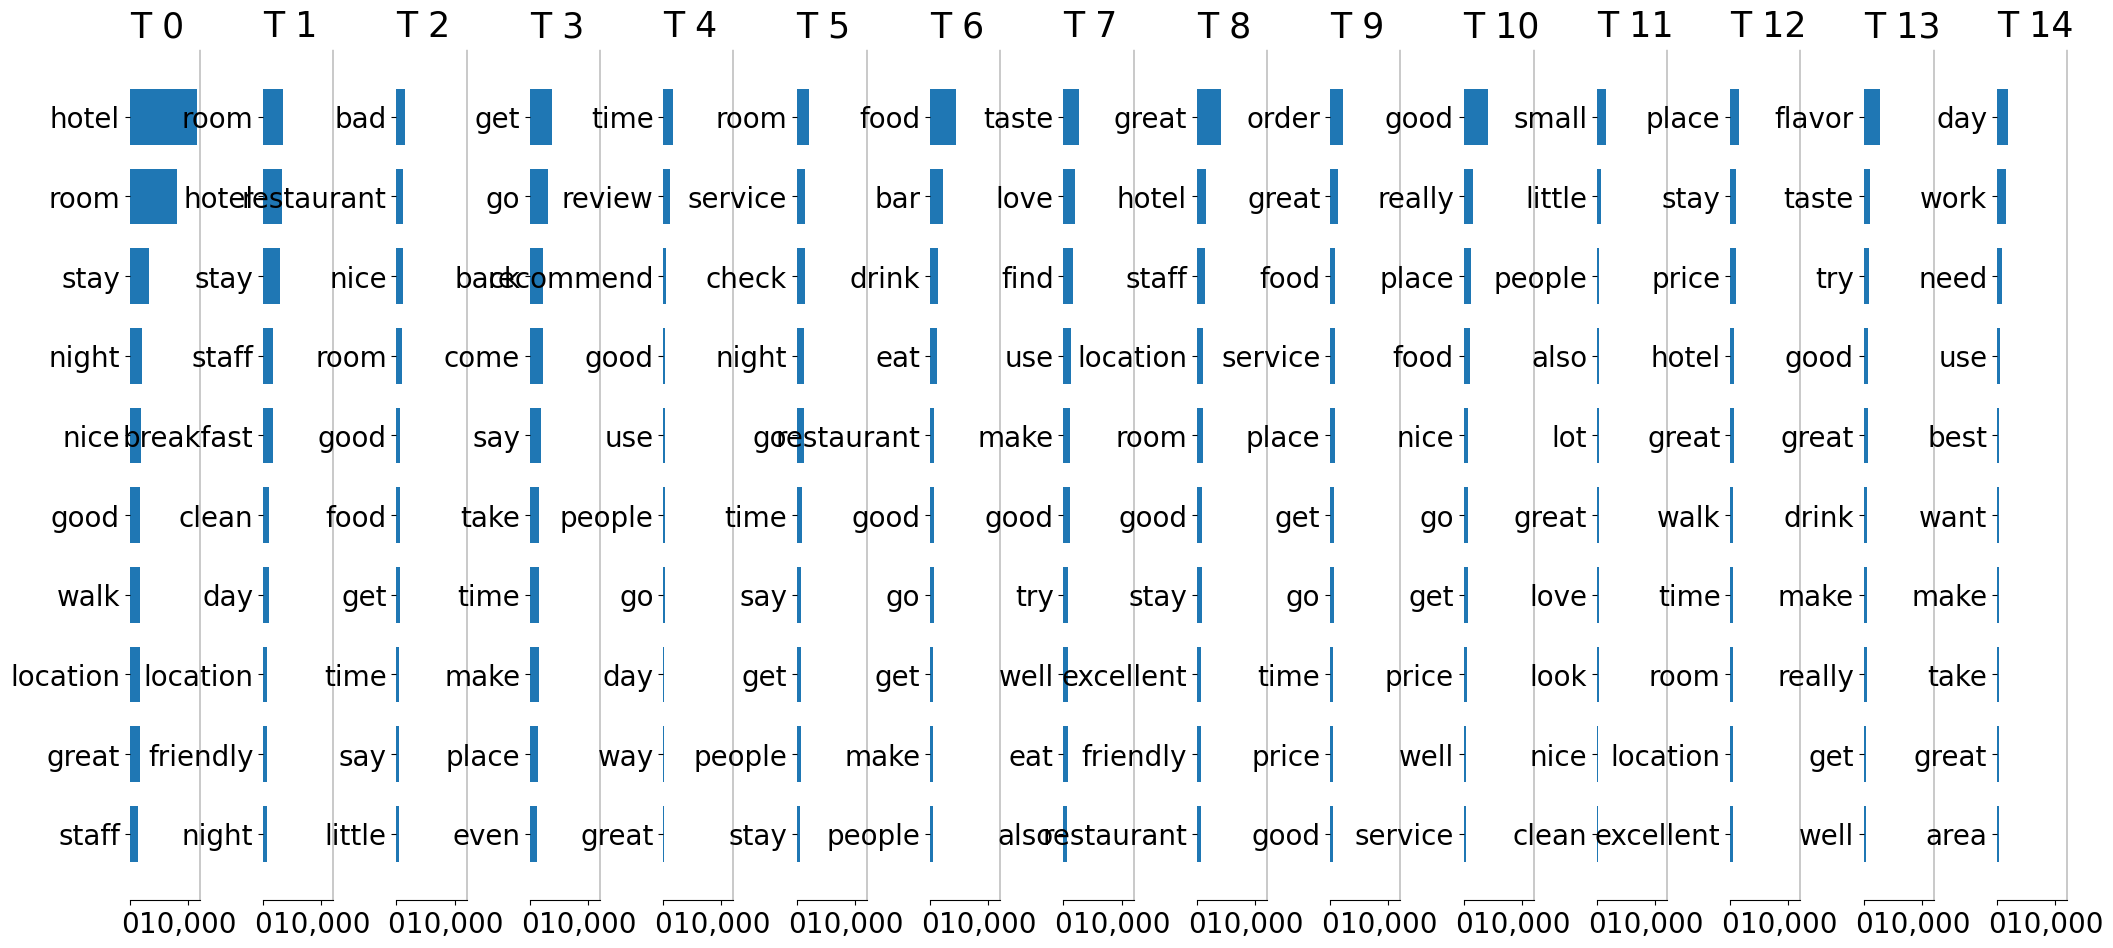

CPU times: user 1min 36s, sys: 1.11 s, total: 1min 37s
Wall time: 1min 45s


In [ ]:
%%time
# OPTIONAL: Visualization of 15 topics
lda_15 = get_lda_component_param(15)

# Topic Classification with LDA

In [ ]:
document_topics = best_lda_model.fit_transform(features)
df['Category'] = document_topics.argmax(axis=1)
df['Max Topic Probability'] = document_topics.max(axis=1)
df

,text_original,text_preprocessed,Sentiment,source,Category,Max Topic Probability
0,I know that there are divided camps when it co...,know divide camp come ship issue part product ...,0,Amazon,3,0.991892
1,The owner responded to my Yelp comment and off...,owner respond yelp comment offer sincere apolo...,1,Yelp,4,0.982353
2,At first I didn't like the Idea of eating a su...,first idea eat sushi place middle desert makin...,2,Yelp,6,0.580407
3,Mass quantities of glop. Skip it.,mass quantity glop skip,0,Yelp,0,0.100000
4,This is my daily morning cup of coffee. I lik...,daily morning cup coffee strong coffee become ...,2,Amazon,2,0.970968
...,...,...,...,...,...,...
29995,This place has a nice selection of Shoes. The ...,place nice selection shoe customer service lac...,1,Yelp,5,0.987324
29996,vet recommended dogs love this kind better tha...,vet recommend dog love kind well one note sens...,2,Amazon,7,0.982353
29997,I first had Popchips last week at a local deli...,first popchips last week local deli miami impr...,2,Amazon,7,0.995522
29998,inexpensive good value chose principal pretty ...,inexpensive good value choose principal pretty...,1,Trip Advisor,1,0.509834


In [ ]:
df.to_csv(f'{base_data_path}/topic_classification_lda_results.csv', index=False)

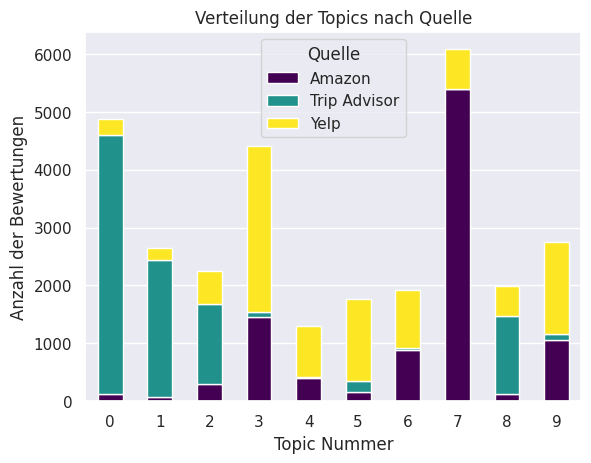

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set()

topic_source_distribution = df.groupby(['Category', 'source']).size().unstack(fill_value=0)

topic_source_distribution.plot(kind='bar', stacked=True, colormap='viridis')

plt.title('Verteilung der Topics nach Quelle')
plt.xlabel('Topic Nummer')
plt.ylabel('Anzahl der Bewertungen')
plt.legend(title='Quelle')

plt.grid(axis='x')

plt.xticks(rotation=0)
plt.show()

In [ ]:
# OPTIONAL: for deeper understanding of the topics: see which topics most certainly belong to this topic
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    display(df[(df["Category"] == 0) & (df["Max Topic Probability"] > 0.90)][:10])

,text_original,text_preprocessed,Sentiment,source,Category,Max Topic Probability
37,"great value pleasant hotel great harbour views rooms, lucky upgraded suite room floor nice nothing local vicinity hotel right near quarry bay mtr getting pretty convenient,",great value pleasant hotel great harbour view room lucky upgrade suite room floor nice nothing local vicinity hotel right quarry bay mtr get pretty convenient,2,Trip Advisor,0,0.990110
39,"just terrific hotel keppler fabulous boutique hotel, location great centrally located quieter street not noise, rooms well-decorated spotless, loved hotel definitely stay time paris,",terrific hotel keppler fabulous boutique hotel location great centrally locate quieter street noise room well decorate spotless love hotel definitely stay time paris,2,Trip Advisor,0,0.991089
67,"great location, stayed crowne plaza berlin 3 nights whilst city break, staff extremely friendly willing help not high standard english.my room sixth floor pleasant scent peach clean comfortable tv english channels cnn bbc sky channels french spanish italian obviously german, location hotel excellent- short walk kadewe huge shopping centre kaiser wilheim gedachtniskirche zoo europa centre.there taxi rank outside want city careful- taxis berlin not cheap, meal hotel breakfast, buffet style lot chose including different types breads meats cereals fruit juices.the complaint hotel prices i.e bar business centre etc.., glass orange juice bar usage time 15 minutes internet business centre costs, overall satisfied stay crowne plaza stay return berlin,",great location stay crowne plaza berlin night whilst city break staff extremely friendly willing help high standard english room sixth floor pleasant scent peach clean comfortable tv english channel cnn bbc sky channel french spanish italian obviously german location hotel excellent short walk kadewe huge shopping centre kaiser wilheim gedachtniskirche zoo europa centre taxi rank want city careful taxis berlin cheap meal hotel breakfast buffet style lot choose include different type bread meat cereal fruit juice complaint hotel price bar business centre etc glass orange juice bar usage time minute internet business centre cost overall satisfied stay crowne plaza stay return berlin,2,Trip Advisor,0,0.996266
78,"perfection, spent 2 weeks italy stayed 7 hotels hotel alessandra topping list favorites, travelers budget pleasantly suprised size room large breakfast spread, staff incredibly friendly, location perfect site seeing, room quiet clean, really expected 145 euros.our warning number unavoidable stairs, type climbed bell tower duomo dome really n't bothered, traveled backpacks not rolling luggage did n't contend lifting, sort physical condition prevent managing 2 flights stairs pathologic overpacker ha ha want consider, perfect spot magical city, someday return florence n't consider staying,",perfection spent week italy stayed hotel hotel top list favorite traveler budget pleasantly suprised size room large breakfast spread staff incredibly friendly location perfect site see room quiet clean really expect euro warn number unavoidable stair type climb bell tower duomo dome really bother traveled backpack roll luggage contend lift sort physical condition prevent manage flight stair pathologic overpacker ha ha want consider perfect spot magical city someday return florence consider stay,2,Trip Advisor,0,0.993130
105,"nice comfortable sister stayed standard room 10th floor, room n't huge spacious, nice clean bathroom beds comfortable giant plasma wall english channels, hotel lobby lovely staff nice.breakfast pretty good early gets quite busy 8am wait table.hotel great location right near ladies night market surrounded plenty restaurants,",nice comfortable sister stay standard room th floor room huge spacious nice clean bathroom bed comfortable giant plasma wall english channel hotel lobby lovely staff nice breakfast pretty good early get quite busy wait table hotel great locati

In [ ]:
# OPTIONAL: for deeper understanding of the topics: see which topics most certainly belong to this topic
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):  # more options can be specified also
    display(df[(df["Category"] == 1) & (df["Max Topic Probability"] > 0.90)][:10])

,text_original,text_preprocessed,Sentiment,source,Category,Max Topic Probability
17,"xmas ny eve holiday 2006 fantastic trip lifetime, spent glorious weeks sydney park hyatt xmas ny celebration, arriving 1am not problem easy friendly check, needed not problem, best location ny fireworks celebration w/a complimentary bottle bubbly, convenient location public transportation concierge prepared questions harley ride tattoo shop,",xmas ny eve holiday fantastic trip lifetime spend glorious week sydney park hyatt xmas celebration arrive problem easy friendly check need problem best location ny fireworks celebration complimentary bottle bubbly convenient location public transportation concierge prepared question harley ride tattoo shop,2,Trip Advisor,1,0.985246
60,"amazing hotel shared junior suite 2 friends 6th floor facing oranienburger strasse, amazing view enormous slanted windows, spectacular room, say best hotel room stayed, room featured breakfast table lounge area flat screen tv dvd player choice cds, double bed individual duvets quite large felt like separate beds, person sofa bed satisfied, loads space room plenty cupboard space, kitchen kettle fridge hob, impeccably clean, bathroom satisfactory, junior suite bathroom separate room opposed queen room bath/shower screened open plan.i viewed queen room impressive, initially chose not breakfast hotel pricey, 2 successive mornings wandering locality search menu satisfy needs recommend hotel buffet breakfast, superb, vegetarian generally suffer comes european buffets plenty choice typical meat options, cereals muesli accompanied variety seeds yogurt divine, plenty fresh breads pastries good coffee make worthwhile, book breakfast night avail reduced rate 12 euro.the staff arcotel velvet friendly helpful, hotel great location want stay mitte interested bohemian area, numerous buses trams underground available outside door hotel shopping districts sites easy reach, recommend welcome card short stays, 48 hour 72 hour travel card available act discount card museums sites,",amazing hotel share junior suite friend th floor face oranienburger strasse amazing view enormous slant window spectacular room say best hotel room stay room feature breakfast table lounge area flat screen tv dvd player choice cd double bed individual duvet quite large felt separate bed person sofa bed satisfied load space room plenty cupboard space kitchen kettle fridge hob impeccably clean bathroom satisfactory junior suite bathroom separate room oppose queen room bath shower screen open plan view queen room impressive initially chose breakfast hotel pricey successive morning wander locality search menu satisfy need recommend hotel buffet breakfast superb vegetarian generally suffer come european buffet plenty choice typical meat option cereal muesli accompany variety seed yogurt divine plenty fresh bread pastry good coffee make worthwhile book breakfast night avail reduce rate euro staff arcotel velvet friendly helpful hotel great location want stay mitte interested bohemian area numerous bus tram available outside door hotel shopping district sit easy reach recommend welcome card short stay hour hour travel card available act discount card museum site,2,Trip Advisor,1,0.992003
110,"n't, stay month period, rooms adequate breakfast good beware downfalls, casino operates illegally-rules not posted vary dealer dealer basis, close look note casino tactics strengthen hotel advantage, does n't convince look cashier line lack thereof not norm casinos san juan, honors members forget daily papers bottled water snacks norm embassy suites.there no elevator parking garage good chance carrying luggage 5 flights stairs, daily internet charge daily parking charge.i pleased hotel stay learned puerto rico marriott chain supercedes hilton chain categories,",stay month period room adequate breakfast good beware downfall casino operate illegally rule post vary dealer dealer basis close look note casino tactic strengthen hotel advant

In [ ]:
# OPTIONAL: for deeper understanding of the topics: see which topics most certainly belong to this topic
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):  # more options can be specified also
    display(df[(df["Category"] == 2) & (df["Max Topic Probability"] > 0.90)][:10])

,text_original,text_preprocessed,Sentiment,source,Category,Max Topic Probability
4,"This is my daily morning cup of coffee. I like strong coffee and this has become my favorite. I do not like the coffee at, say, Dunkin' Donuts. In the afternoons, I like Coffee People decaf or Timothy's decaf Hazelnut. But for a good, regular cup, Green Mountain Dark Magic Extra Bold is it.",daily morning cup coffee strong coffee become favorite coffee say dunkin donut afternoon coffee people decaf timothy decaf hazelnut good regular cup green mountain dark magic extra bold,2,Amazon,2,0.970968
49,"These things are great! I don't like the granola-like crunchiness of most oatmeal bars, but these are soft. No high fructose corn syrup or other unnatural, unhealthy stuff. Can't say enough good things!",thing great granola crunchiness oatmeal bar soft high fructose corn syrup unnatural unhealthy stuff say enough good thing,2,Amazon,2,0.985246
81,"dissapointed time bali apart fact got sick room clean ok kettle took hour heat got boiling stage bathroom toilet grotty needs bottle bleach sheets towels dirty grey not white like supposed, restaurant not best apart expensive not good food service breakfast shocker, advertise sign board days things dont change plans don t happen fruit carving art not reccommend place friends family, good pools awesome,,",dissapointed time bali apart fact get sick room clean ok kettle take hour heat get boiling stage bathroom toilet grotty need bottle bleach sheet towel dirty grey white suppose restaurant best apart expensive good food service breakfast shocker advertise sign board day thing dont change plan happen fruit carve art reccommend place friend family good pool awesome,0,Trip Advisor,2,0.994737
87,"overall good missed details just returned stay ppc friends, overall resort nice, food good not great just good, staff good, rooms nice, resort just work smooth details really class.arrived late punta cana 8 hours ice storm east coast total incompetentcy whomever runs philadelphia airport, easily worst airport nation immediatly jumped baggage handlers punta cana airport, aggressive, asked cab hussled cab hindsight probably working baggage handler, ride ppc usage headlights exciting cab sort mechanical problem, suggest resort send cab instead using cabs hanging airport.when arrived resort confusion expedia booking split resevation 4 people credit cards, expedia puts tickets rooms credit card, met bellman named eddie wilson true shining bright spot trip taken room not jetted tub upgrade paid, eddie wilson speaks english rareity ppc got phone desk told upgraded room, catch limited spanish desk wanted room night fix tommorrow, eddie insisted fix problem, stayed 30 minutes phone calls later upgraded room, unpacked eddie wilson went desk got keys changed, wife tipped 10 point looked tried best care us.here started miss details necessary true 5 star resort, unable make golf starting times greens fees included package guest relations desk closed, unable lock room safe desk, day friend attempted golf starting time guest relations told just golf course cancelations, course resort includes golf package 15 minute ride resort, got told starting times, tried make starting times rest week 2 choices 7:20 11:45, nothing betweenso scheduled, returned resort wives unable beach towels ran missed remainder stay typical resort eat drink play lot golf, walk lot residential area lobby area 1/4 mile not shuttles running anohter missed prepared, target groups ppc euorpeans families not american couples.we extended room 2 pm away day fried eddie wilson pick cab airport, smooth way out.if ppc ask eddie wilsonget early beach towelmake starting times stay asap golf courseeat lunch beach buffet oncelearn spanish go.do notrely guest relations overwhelmedexpect staff waitstaff speak englishexpect snack 4 6 food service shuts downgo near casino just burn money faster,",overall good miss detail return stay ppc friend overall resort nice food good great good

In [ ]:
# OPTIONAL: for deeper understanding of the topics: see which topics most certainly belong to this topic
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):  # more options can be specified also
    display(df[(df["Category"] == 4) & (df["Max Topic Probability"] > 0.90)][:10])

,text_original,text_preprocessed,Sentiment,source,Category,Max Topic Probability
1,The owner responded to my Yelp comment and offered sincere apologies and invited me back for any drink on her. Nice!\n\n(I am rolling over the three stars as one must in order to post here...I have not had a chance to take the owner up on her lovely offer),owner respond yelp comment offer sincere apology invite back drink nice roll star order post chance take owner lovely offer,1,Yelp,4,0.982353
5,"I just ordered two more sets of this because I am afraid of running out, it is that good. It reminds me of all childish things that were tasty and fun at the beach, parks, picnics, etc. Please buy this product and keep this company in business so that I will never have to do without this small pleasure. Right now the three pack is on sale and with the Prime Shipping, it is a real bargain. Thanks",order set afraid run good reminds childish thing tasty fun beach park picnic etc please buy product keep company business never small pleasure right pack sale prime ship real bargain thanks,2,Amazon,4,0.982353
32,"I read the other reviews, I don't see how they earn a three star. Maybe their attitude change for the worest; maybe its the summer heat, In my book that owner lady is definately NOT FRIENDLY !!! she is a bitch !!, she brought out the wrong oder, we took a few bit before we realizing it was not what we ordered, she insisted we pay for it anyway - because we already eat it (three bits worth). The man is nicer, he came out and take care of our complain. \nThe food is pretty much like other Americanized chinese restaurant. - Cheap and plenty.\nAs for me, I won't be back here again; plenty Other good Chinese restaurant to choose from.",read review see earn star maybe attitude change worest maybe summer heat book owner lady definately friendly bitch bring wrong oder take bit realize order insisted pay anyway already eat bit worth man nicer come take care complain nthe food pretty much americanize chinese restaurant cheap plenty na back plenty good chinese restaurant choose,0,Yelp,4,0.992562
163,We ordered the berbere directly from the teenytinyspice company and were very pleased. It arrived only 4 days after I ordered it and came with several different recipe cards. There was also a free spice sample. The berbere blend was incredible in a Doro Wat recipe we took from a Washington Post article from 2010 about the spice. Yum!,order berbere directly teenytinyspice company please arrived day order come several different recipe card also free spice sample berbere blend incredible doro wat recipe take washington post article spice yum,2,Amazon,4,0.985246
200,"Didn't appreciate the poor customer service & the inability to properly fold a burrito @ this location. The rice was undercooked & felt like hard seeds in my mouth. The steak was very chewy & reminded me of jerky. The server was also chewing gum while preparing my food - gross & not OK. Oh, I almost forgot that I came @ a very inconvenient time for the staff because even though I was the only customer, I had the nerve to interrupt their gossip session. I will definitely be contacting corporate about my experience because I'm sure I can find a much better overpriced burrito elsewhere. I'm upset that I don't have the option to give 0 stars.",appreciate poor customer service inability properly fold burrito location rice undercooked felt hard seed mouth steak chewy remind jerky server also chew gum prepare food gross ok oh almost forgot come inconvenient time staff even customer nerve interrupt gossip session definitely contact corporate experience sure find much well overprice burrito elsewhere upset option star,0,Yelp,4,0.991089
369,"i tried this shake & bake once its quite tasty, I ordered after reading other reviews",tried shake bake quite tasty order reading review,2,Amazon,4,0.957143
375,Foods is great and very healthy. Would come here more often if it wasn't for the service. Especially when it's busy an